# Q-Learning


## Cliff walking


    This is a simple implementation of the Gridworld Cliff
    reinforcement learning task.
    Adapted from Example 6.6 (page 106) from Reinforcement Learning: An Introduction
    by Sutton and Barto:
    http://incompleteideas.net/book/bookdraft2018jan1.pdf
    With inspiration from:
    https://github.com/dennybritz/reinforcement-learning/blob/master/lib/envs/cliff_walking.py
    The board is a 4x12 matrix, with (using Numpy matrix indexing):
        [3, 0] as the start at bottom-left
        [3, 11] as the goal at bottom-right
        [3, 1..10] as the cliff at bottom-center
    Each time step incurs -1 reward, and stepping into the cliff incurs -100 reward
    and a reset to the start. An episode terminates when the agent reaches the goal.
    
  ![cliffworld](https://drive.google.com/uc?id=1FbykOcXgrhxbz7goBhQWztR6apQ2gPUV)


  ![q-learning](https://drive.google.com/uc?id=1U0KWkrCGIZ0AenGyorNGlAN88Yp8us-N)

In [65]:
%matplotlib inline

import gym
import matplotlib
import numpy as np
import sys
from collections import defaultdict
import itertools
import seaborn as sns


class Q_Learning:
  
  
  def __init__(self, 
               num_episodes = 10000, 
               verbose=False, 
               discount_factor=0.9, 
               alpha=0.5, 
               epsilon=0.1):
    self.verbose = verbose
    self.nE = num_episodes
    self.df=discount_factor
    self.alpha=alpha
    self.epsilon=epsilon  
    self.greedy_pol = None
    self.Q = None

######################################################################
############################  Core Functons ##########################
###################################################################### 
  def _td_update(self, state, action, env):
    '''
        updated Q table for a given state/action pair
        Input:
              State : the current state
              actions: the selected action
              env: game enviroment
    '''
    # take action
    next_state, reward, done, _ = env.step(action)
    # get best action in next state
    best_next_action = np.argmax(self.Q[next_state])
    # calculate TD target = r + gamma*armaxa Q(s',a)
    td_target = reward + self.df * self.Q[next_state][best_next_action]
    # calculate error: target - Q(s,a)
    td_delta = td_target - self.Q[state][action]
    # updated Q-Table: Q(s,a) += alpha * td_error
    self.Q[state][action] += self.alpha * td_delta
    self.greedy_pol.set_Q(self.Q.copy())
    return done, next_state

######################################################################
############################  Helper Functons ########################
######################################################################
    
  def _init_model(self, env):
    self.Q = defaultdict(lambda: np.zeros(env.action_space.n))
    self.greedy_pol = Epsilon_greedy_policy(self.Q.copy(), self.epsilon)
    

  def run_episode(self, env):
    '''
          Plays one round of the game and updates Q table
          Input enviroment to learn
        
    '''
    
    state = env.reset()
    
    # is step count
    for t in itertools.count():
            
      # Take a step
      action_probs = self.greedy_pol.get_policy_for_state(state)
      action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
      # update Q table
      done, next_state = self._td_update(state, action, env)

      # stop after 50 steps or when game is finished
      if done or t == 50:
          break

      state = next_state
            
      
  def train(self, env, force_init=False):
    '''
          Trains Q learner for a given enviroment
          Input: env enviroment you want to train on
    '''
    if self.Q is None or self.C is None or force_init:
      self._init_model(env)
    
    for i_episode in range(1, self.nE + 1):

      if i_episode % 10 == 0 and self.verbose:
          print("Episode %i" % (i_episode))
          sys.stdout.flush()
      
      self.run_episode(env)


######################################################################
############################  Helper Functons ########################
######################################################################

class Greedy_policy():
  
  def __init__(self, Q):
    self.Q = Q
  
  def set_Q(self, Q):
    self.Q = Q
    
  def get_policy_for_state(self, s):
    A = np.zeros_like(self.Q[s], dtype=float)
    best_action = np.argmax(self.Q[s])
    A[best_action] = 1.0
    return A
  
class Epsilon_greedy_policy(Greedy_policy):
  
  def __init__(self, Q, epsilon):
    super(Epsilon_greedy_policy, self).__init__(Q)
    self.epsilon = epsilon
      
  def get_policy_for_state(self, s):
    greedy_policy = super(Epsilon_greedy_policy, self).get_policy_for_state(s)
    return self.make_greedy_policy_epsilon_greedy(greedy_policy)

  def make_greedy_policy_epsilon_greedy(self, greedy_pol):
    best_action = np.argmax(greedy_pol)
    greedy_pol += self.epsilon/len(greedy_pol)
    greedy_pol[best_action] -= self.epsilon
    return greedy_pol

def mk_heatmap(Q, action, action_name):
  world = np.zeros(env.shape)
  for s, v in q_learner.Q.items():
    pos = np.unravel_index(s, env.shape)
    world[pos] = v[action]
  sns.set(rc={'figure.figsize':(11.7,5.27)})
  sns.heatmap(world, vmax = 10, vmin = -10, annot=True, cmap = sns.diverging_palette(240, 10, n=9), linewidths=.5, linecolor='black').set_title(action_name)

In [66]:
from gym.envs.toy_text.cliffwalking import CliffWalkingEnv

env = CliffWalkingEnv()
q_learner = Q_Learning(num_episodes=100)
q_learner.train(env)

env.render()
world = np.zeros(env.shape)
for s, v in q_learner.Q.items():
  pos = np.unravel_index(s, env.shape)
  world[pos] = np.argmax(v)
# UP:0, RIGHT: 1, DOWN: 2, LEFT: 3
world

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  x



array([[3., 1., 1., 1., 1., 2., 0., 1., 1., 1., 2., 2.],
       [1., 0., 3., 0., 1., 2., 1., 2., 1., 2., 1., 2.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

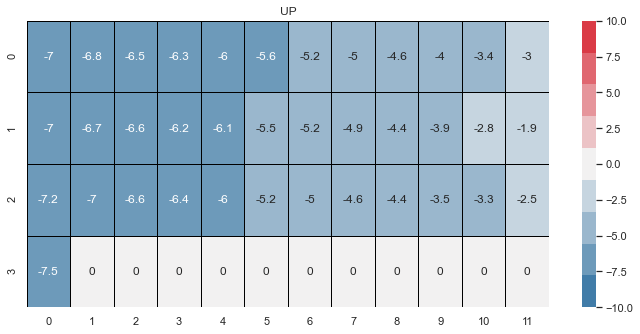

In [67]:
mk_heatmap(q_learner.Q, 0, 'UP')

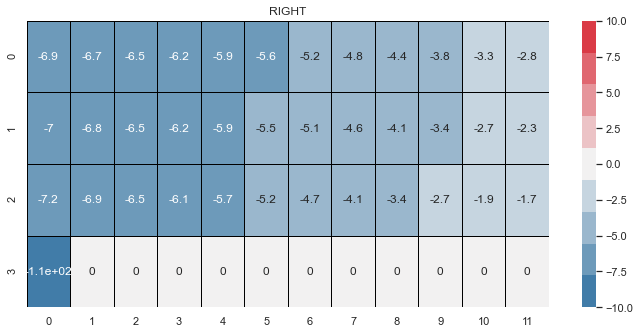

In [68]:
mk_heatmap(q_learner.Q, 1, 'RIGHT')

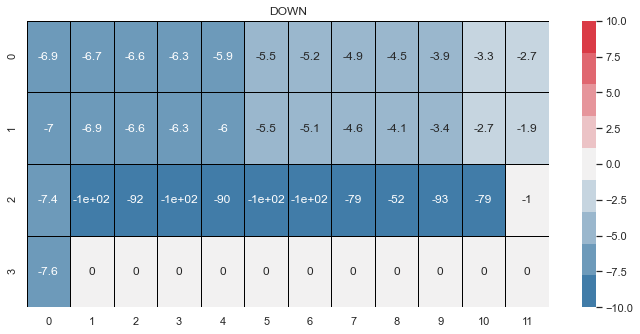

In [69]:
mk_heatmap(q_learner.Q, 2, 'DOWN')

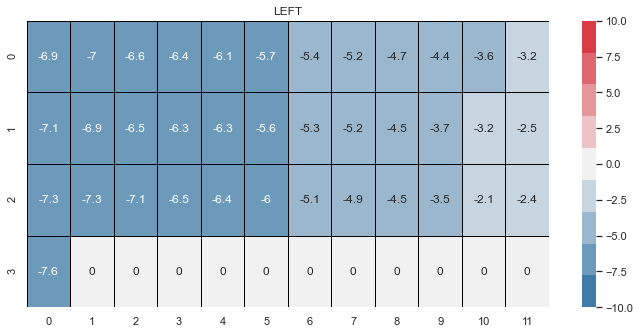

In [70]:
mk_heatmap(q_learner.Q, 3, 'LEFT')

# Deep Q Networks

In [71]:
# https://github.com/cyoon1729/deep-Q-networks
# https://github.com/andri27-ts/Reinforcement-Learning
# https://github.com/Kaixhin/Rainbow
# https://github.com/dennybritz/reinforcement-learning
# https://github.com/the-computer-scientist/OpenAIGym/blob/master/PrioritizedExperienceReplayInOpenAIGym.ipynb
# https://jaromiru.com/2016/11/07/lets-make-a-dqn-double-learning-and-prioritized-experience-replay/

  ![2-1](https://drive.google.com/uc?id=1WxZGbZ-7KBVOie4V4uuxT0dVnqclFno-)


  ![2-2](https://drive.google.com/uc?id=1cf-GIa1P9O3tgFfxCh8rKx8TqFg4JlNU)


  ![2-3](https://drive.google.com/uc?id=1ZhspfBhKkT8l1AOG3gMtxi9JAHZLaTHm)

In [72]:
import gym
import utils
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from collections import namedtuple

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

import torch
import torch.autograd as autograd
import torch.nn as nn
from enum import Enum

import copy

## Replay Buffer

In [73]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward', 'done'))

class ReplayMemory(object):
    '''
          A simple memory for storing episodes where each episodes 
          is a names tuple with (state, action, next_state, reward, done)
    '''
    def __init__(self, capacity):
        '''
            Initialize memory of size capacity
            Input: Capacity : int 
                        size of the memory

            output: initialized ReplayMemory object
        '''
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        '''
            input *args : list  *args is list for transition 
            [state, action, next_state, reward, done] and add
            transition to memory.
            Returns : None
        '''
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
          '''
              Randomly sample transitions from memory
              Input batch_size : int
                      numer of transition to sample
              Output:  namedtuple
                        Namedtupe with each field contains a list of data points

          '''
          batch = random.sample(self.memory, batch_size)
          return Transition(*zip(*batch))


    def __len__(self):
        '''
              returns current size of memory
        '''
        return len(self.memory)

## Deep Q Neural network

In [74]:
class Abstract_DQNN(nn.Module):
    '''
            Abstract class gives skelleton that all DQN algos should implement/inherit

            DQNN are the neural network of the Deep Q learning part. Deep Q learning consits of netowkr and agent.
    '''
    def __init__(self, input_dim, output_dim):

        '''
            input_dim : tuple  shape of enviroment state
            output_dim: int    number of actions  
        '''
        super(Abstract_DQNN, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self._init_fc()
        self._init_o()

    def _init_fc(self):
        '''
              Initialize the feature generation part of the NN
        '''
        pass
    
    def _init_o(self):
        '''
              Initialize the output layer of the NN
        '''
        pass
    
    def _forward_fc(self, state):
        '''
              Pass the state trough the feature layer generating hidden state (i.e. features)
        '''
        pass

    def _forward_o(self, fc):
        '''
              pass features from fc layer trough the output layer
        '''
        pass

    def forward(self, state):
        '''
            Complete forward pass from state to otput
            Input: State: list   state of the enviroment
            Output: Value function for each action in input state

        '''
        features = self._forward_fc(state)
        features = features.view(features.size(0), -1)
        out = self._forward_o(features)
        return out


class FCDQN(Abstract_DQNN):

    '''
          Fully connected Nural network for Q-Learning
    '''
    
    def _init_fc(self):
        '''
              Initialize the feature generation part of the NN
              Here it is two dense layer
        '''
        self.fc = nn.Sequential(
            nn.Linear(self.input_dim[0], 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
        )

    def _init_o(self):
        '''
              pass features from fc layer trough the output layer
              here a single dense layer
        '''
        self.o = nn.Sequential(
            nn.Linear(256, self.output_dim)
        )

    def _forward_fc(self, state):
        '''
              Pass the state trough the feature layer generating hidden state (i.e. features)
              Input state env.state state of the enviroment
              returns hidden state of fc layers
        '''
        return self.fc(state)

    def _forward_o(self, fcs):
        '''
              pass features from fc layer trough the output layer
              Input output hidden layer of fc layer
              Output value state action function for each action in state
        '''
        return self.o(fcs)


class ConvDQN(nn.Module):    
    def _init_fc(self):
        self.conv_net = nn.Sequential(
            nn.Conv2d(self.input_dim[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )

        fc_input_dim = self.feature_size()

        self.fc = nn.Sequential(
            nn.Linear(self.fc_input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, self.output_dim)
        )


    def _init_o(self):
        self.o = nn.Sequential(
            nn.Linear(128, self.output_dim)
        )

    def _forward_fc(self, state):
        features = self.conv_net(state)
        features = features.view(features.size(0), -1)
        return  self.fc(features)

    def _forward_o(self, fcs):
        return self.o(fcs)

    def _forward_o(self, fcs):
        return self.o(fcs)

    def feature_size(self):
        return self.conv_net(autograd.Variable(torch.zeros(1, *self.input_dim))).view(1, -1).size(1)



In [75]:
class RL_NN(Enum):
       FCDQN = 1
       ConvDQN = 2
       Dllng_FCDQN = 3
       Noiy_Dllng_FCDQN = 4
  
class NN_Factory:

  '''
      Factory for generating Deep Q neural networks
  '''
  
  def __init__(self):
    self.registry = {}
    self.register(RL_NN.FCDQN, FCDQN)
    self.register(RL_NN.ConvDQN, ConvDQN)
    
  def register(self, key, const):

    '''
        Registers a cunstructor to a specific RL_NN enum
        Key : Enum enum key for costructor
        const: Constructor for NN class
    '''
    self.registry[key] = const
    
  def get(self, key):
    '''
        retrieves a registered constructor for a given Enum key

        Input: key: Enum key for constructor
    '''
    if key in self.registry:
      return self.registry[key]
    else:
      raise Exception('%s Constructor not registered')

## Deep Q Agent

In [76]:
class DQN_Agent:

    '''
          Base model for Deep Q-Learning Agents
    '''

    def __init__(self, env, NN_class, replay_buffer,
                 learning_rate=0.001, gamma=0.99, update_target = 100, eps=1, 
                  eps_decay=0.9, eps_min= 0.01):
        '''
              Iniitialize Deep Q Agent

              Input:

                        env: openai gym enviroment
                        NN_class: Abstract_DQNN Neural network class for neural network part of Deep Q-Learning
                        replay_buffer: Replay Bufer to store Transitions
                        learning_rate: learning rate to update neural network
                        gamma: future discount rate
                        update_target: step % update_target ==0 is when target network gets updated
                        eps: epsilon for choosing random action
                        eps_decay: rate at which epsilon decays
                        eps_min: minimal epsilon value 
        '''
        self.env = env
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.replay_buffer = replay_buffer
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model         = NN_class(env.observation_space.shape, env.action_space.n)
        self.target_model  = NN_class(env.observation_space.shape, env.action_space.n)
        self.optimizer = torch.optim.Adam(self.model.parameters())
        self.MSE_loss = nn.MSELoss()
        self.update_target = update_target
        self.i = 0
        self.eps = eps
        self.eps_decay = eps_decay
        self.eps_min = eps_min


######################################################################
############################  Core Functons ##########################
######################################################################

    def get_action(self, state):
        '''
              epsilon greedy selection of action:
                    with P(1-epsilon):
                        select greedy action
                    else:
                        select random action

              Input: state: env.state state enviroment
              output: action with highest value fucntion for input in state
        '''
        if(np.random.uniform() < self.eps):
            return self.env.action_space.sample()
        else:
            state = torch.FloatTensor(state).float().unsqueeze(0).to(self.device)
            qvals = self.model.forward(state)
            return np.argmax(qvals.cpu().detach().numpy())


    def compute_loss(self, batch):
        '''
            calculates loss for a given batch
            Input: batch: a batch of Transitions

            output: MSE loss of predicted value functions and gamma * value fuction(next state)

        '''

        states, actions, rewards, next_states, dones = self.__get_tensors_from_batch__(batch)
        # get model predictions of Q
        q_predictions = self._predict_q(states, actions)

        # get y_i (i.e. a better estimate of Q values)
        expected_Q = self._yi(next_states, dones, rewards)
        
        loss = F.mse_loss(q_predictions, expected_Q.detach())
        
        return loss

    def _yi(self, next_states, dones, rewards):
        '''
              retursn td error for each Transitions
              Input:
                    next_states: list of future tates
                    dones: list of dones
                    rewards: list of rewards
              Output:
                    Td error for each Transition in Batch
                
        '''
        max_next_Q = self._next_max_Q(next_states)
        y_i = rewards + (1 - dones) * self.gamma * max_next_Q
        return y_i

    def train(self, env, max_episodes, max_steps, batch_size):
        '''
                trains Deep Q Agent for a given enviroment
                Input:
                        env: enviroment to train on
                        max_episodes: number of epsiodes to play
                        max_steps: number of steps to take in an epsiode
                        batch_size: size of batch
        '''
        episode_rewards = []

        for episode in range(max_episodes):
            state = env.reset()
            episode_reward = 0

            for step in range(max_steps):
                action = self.get_action(state)
                next_state, reward, done, _ = env.step(action)
                reward = reward if not done else -10
                self.replay_buffer.push(state, action, next_state, reward, done)
                episode_reward += reward

                if len(self.replay_buffer) > batch_size:
                    self.update(batch_size)   

                if done or step == max_steps-1:
                    episode_rewards.append(episode_reward)
                    self.update_eps()
                    print("Episode " + str(episode) + ": " + str(episode_reward), '\t', self.eps)
                    break

                state = next_state

        return episode_rewards

######################################################################
############################  Helper Functons ########################
######################################################################

    def _predict_q(self, states, actions):
        '''
              Get value function for actions and state for batch of states of actions
              Input: states : list of states
                      actions: list of actions
              Output: list of Q values for each actions/state pair
        '''
        return self.model.forward(states).gather(1, actions).to(self.device)

    def __get_tensors_from_batch__(self, batch):
        '''
              maps list values from abtch to pytorch tensors

              Input: batch: list of Transitions

              output: pytorch tensors of all Transitions values
        '''
        states = torch.FloatTensor(batch.state, device=self.device)
        actions = torch.LongTensor(batch.action, device=self.device)
        rewards = torch.FloatTensor(batch.reward, device=self.device)
        next_states = torch.FloatTensor(batch.next_state, device=self.device)
        dones = torch.FloatTensor(batch.done, device=self.device)
        
        # resize tensors
        actions = actions.view(actions.size(0), 1)
        dones = dones.view(dones.size(0), 1)
        rewards = rewards.view(rewards.size(0), 1)

        return states, actions, rewards, next_states, dones

    def _next_max_Q(self, next_states):
        '''
              returns maxt Q value for a batch of future states
              Input: next_states: list of future tates
              Output: max Q-value for each future state
        '''
        next_Q = self.target_model.forward(next_states).to(self.device)
        max_next_Q = torch.max(next_Q, 1)[0]
        return max_next_Q.view(max_next_Q.size(0), 1)



    def update(self, batch_size):

        '''
              Forward and backward pass for a batch
                Input: 
                        batch_size: number of Transitions to be sampled from memory
        '''
        batch = self.replay_buffer.sample(batch_size)
        loss = self.compute_loss(batch)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Copy the moving NN in the target NN
        if self.i % self.update_target == 0:
          self.target_model.load_state_dict(self.model.state_dict())
        self.i += 1

    def update_eps(self):
      '''
              perform epsilon decay
      '''
      if self.eps > self.eps_min:
          self.eps *= self.eps_decay



In [77]:
env_id = "CartPole-v1"
MAX_EPISODES = 100
MAX_STEPS = 500
BATCH_SIZE = 32
nn_fac = NN_Factory()
env = gym.make(env_id)
buffer = ReplayMemory(10000)
agent = DQN_Agent(env, nn_fac.get(RL_NN.FCDQN), buffer)
episode_scores = agent.train(env, MAX_EPISODES, MAX_STEPS, BATCH_SIZE)

Episode 0: 7.0 	 0.9
Episode 1: 5.0 	 0.81
Episode 2: 8.0 	 0.7290000000000001
Episode 3: 6.0 	 0.6561000000000001
Episode 4: 17.0 	 0.5904900000000002
Episode 5: 25.0 	 0.5314410000000002
Episode 6: 11.0 	 0.47829690000000014
Episode 7: 106.0 	 0.43046721000000016
Episode 8: 59.0 	 0.38742048900000015
Episode 9: 64.0 	 0.34867844010000015
Episode 10: 101.0 	 0.31381059609000017
Episode 11: 65.0 	 0.28242953648100017
Episode 12: 128.0 	 0.25418658283290013
Episode 13: 138.0 	 0.22876792454961012
Episode 14: 100.0 	 0.2058911320946491
Episode 15: 98.0 	 0.1853020188851842
Episode 16: 127.0 	 0.16677181699666577
Episode 17: 169.0 	 0.1500946352969992
Episode 18: 134.0 	 0.13508517176729928
Episode 19: 167.0 	 0.12157665459056936
Episode 20: 210.0 	 0.10941898913151243
Episode 21: 134.0 	 0.0984770902183612
Episode 22: 128.0 	 0.08862938119652508
Episode 23: 135.0 	 0.07976644307687257
Episode 24: 141.0 	 0.07178979876918531
Episode 25: 137.0 	 0.06461081889226679
Episode 26: 137.0 	 0.05

In [78]:
env = utils.wrap_env(gym.make("CartPole-v1"))
observation = env.reset()
total_raward_rnd = 0
agent.eps = 0
while True:
    env.render()
    action = agent.get_action(observation)
    observation, reward, done, info = env.step(action)
    total_raward_rnd += reward
    if done: 
      break;
print(total_raward_rnd)
env.close()
utils.show_video()

226.0


# Rainbow

Rainbow algorithm consits of a list of improvements:



*   Double deep Q-Learning
*   Duelling Deep Q-Learning
*   Noisy Nets
*   N look ahead Buffer
*   Prioritized Experience Replay
*   Distributed Q-Learning



## Double Deep Q Learning

![2-4](https://drive.google.com/uc?id=1tnCUxytMbntOFZoanJbhiRCdkURwU8tc)



In [79]:
class Double_DQN_Agent(DQN_Agent):
    
    '''
    Double Deep Q Agent extens on the original Deep Q Agent
    '''

    def _next_max_Q(self, next_states):
        '''
        Calculates Max Q Value for next_states using double deep Q-Learning
        Input:
        next_states: list of next states
        '''
        #Actions our model would select based on next state
        double_max_action = self.model(next_states).max(1)[1]
        double_max_action = double_max_action.detach()
        # calculate Q vales for all actions our model would take based on next state
        target_output = self.target_model(next_states)
        max_next_Q = torch.gather(target_output, 1, double_max_action[:,None])
        return max_next_Q.view(max_next_Q.size(0), 1)

In [80]:
env_id = "CartPole-v1"
MAX_EPISODES = 200
MAX_STEPS = 500
BATCH_SIZE = 32
nn_fac = NN_Factory()
env = gym.make(env_id)
buffer = ReplayMemory(10000)
agent = Double_DQN_Agent(env, nn_fac.get(RL_NN.FCDQN), buffer)
episode_scores = agent.train(env, MAX_EPISODES, MAX_STEPS, BATCH_SIZE)

Episode 0: -2.0 	 0.9
Episode 1: 28.0 	 0.81
Episode 2: 6.0 	 0.7290000000000001
Episode 3: 3.0 	 0.6561000000000001
Episode 4: 2.0 	 0.5904900000000002
Episode 5: 7.0 	 0.5314410000000002
Episode 6: 17.0 	 0.47829690000000014
Episode 7: 5.0 	 0.43046721000000016
Episode 8: 2.0 	 0.38742048900000015
Episode 9: 4.0 	 0.34867844010000015
Episode 10: 3.0 	 0.31381059609000017
Episode 11: 8.0 	 0.28242953648100017
Episode 12: 6.0 	 0.25418658283290013
Episode 13: 1.0 	 0.22876792454961012
Episode 14: 12.0 	 0.2058911320946491
Episode 15: 26.0 	 0.1853020188851842
Episode 16: 60.0 	 0.16677181699666577
Episode 17: 35.0 	 0.1500946352969992
Episode 18: 46.0 	 0.13508517176729928
Episode 19: 43.0 	 0.12157665459056936
Episode 20: 58.0 	 0.10941898913151243
Episode 21: 148.0 	 0.0984770902183612
Episode 22: 142.0 	 0.08862938119652508
Episode 23: 170.0 	 0.07976644307687257
Episode 24: 179.0 	 0.07178979876918531
Episode 25: 178.0 	 0.06461081889226679
Episode 26: 270.0 	 0.05814973700304011
E

## Duelling Deep Q-Learning


![2-5](https://drive.google.com/uc?id=1PnvhnttEDxfbTSiz3vLPQqshkA1KeChk)


![2-5](https://drive.google.com/uc?id=1BciTQbxxosEB-Qdfk9v_N4I2il2HHyD7)


In [81]:
class Duelling_DQNN(Abstract_DQNN):
    '''
    Extend Deep Q learning Networks to Duelling Netowrks
    '''
    def _init_fc(self):
        '''
        Feature generation is unchanged to vanilla deep Q-LEarning
        '''
        self.fc = nn.Sequential(
        nn.Linear(self.input_dim[0], 128),
        nn.ReLU(),
        nn.Linear(128, 128),
        nn.ReLU(),
        )

    def _init_o(self):
        '''
        Output layer consits of q-value extimation and adventage function for actions
        value_stream: calculates Q-value (output one value)
        advantage_stream: calucaltes advantage value for each action in state
        '''
        self.value_stream = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
        self.advantage_stream = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, self.output_dim)
        )
        self.o = nn.Sequential(
            nn.Linear(128, self.output_dim)
        )

    def _forward_fc(self, state):
        return self.fc(state)

    def _forward_o(self, fcs):
        '''
        returns q-value for each action for a given hidden feature state
        '''
        values = self.value_stream(fcs)
        advantages = self.advantage_stream(fcs)
        # return value + (adventage - mean(adventage))
        return values + (advantages - advantages.mean())

In [82]:
env_id = "CartPole-v1"
MAX_EPISODES = 200
MAX_STEPS = 500
BATCH_SIZE = 32

# Add new NN architecture
nn_fac = NN_Factory()
nn_fac.register(RL_NN.Dllng_FCDQN, Duelling_DQNN)

env = gym.make(env_id)
buffer = ReplayMemory(10000)
agent = Double_DQN_Agent(env, nn_fac.get(RL_NN.Dllng_FCDQN), buffer)
episode_scores = agent.train(env, MAX_EPISODES, MAX_STEPS, BATCH_SIZE)

Episode 0: 11.0 	 0.9
Episode 1: -1.0 	 0.81
Episode 2: -1.0 	 0.7290000000000001
Episode 3: 3.0 	 0.6561000000000001
Episode 4: 3.0 	 0.5904900000000002
Episode 5: 2.0 	 0.5314410000000002
Episode 6: 10.0 	 0.47829690000000014
Episode 7: -2.0 	 0.43046721000000016
Episode 8: 8.0 	 0.38742048900000015
Episode 9: 0.0 	 0.34867844010000015
Episode 10: 1.0 	 0.31381059609000017
Episode 11: 0.0 	 0.28242953648100017
Episode 12: -1.0 	 0.25418658283290013
Episode 13: 0.0 	 0.22876792454961012
Episode 14: 0.0 	 0.2058911320946491
Episode 15: -1.0 	 0.1853020188851842
Episode 16: -2.0 	 0.16677181699666577
Episode 17: 0.0 	 0.1500946352969992
Episode 18: 2.0 	 0.13508517176729928
Episode 19: 25.0 	 0.12157665459056936
Episode 20: 34.0 	 0.10941898913151243
Episode 21: 74.0 	 0.0984770902183612
Episode 22: 324.0 	 0.08862938119652508
Episode 23: 196.0 	 0.07976644307687257
Episode 24: 369.0 	 0.07178979876918531
Episode 25: 145.0 	 0.06461081889226679
Episode 26: 117.0 	 0.05814973700304011
Ep

## Noisy Nets

![2-5](https://drive.google.com/uc?id=1F0Xi9XRSn3ztxEUXoJ7ygdSVvZYs5z79)


In [83]:
import math
# Factorised NoisyLinear layer with bias
# source https://github.com/Kaixhin/Rainbow/blob/master/model.py
class NoisyLinear(nn.Module):
    def __init__(self, in_features, out_features, std_init=0.5):
      super(NoisyLinear, self).__init__()
      self.in_features = in_features
      self.out_features = out_features
      self.std_init = std_init
      self.weight_mu = nn.Parameter(torch.empty(out_features, in_features))
      self.weight_sigma = nn.Parameter(torch.empty(out_features, in_features))
      self.register_buffer('weight_epsilon', torch.empty(out_features, in_features))
      self.bias_mu = nn.Parameter(torch.empty(out_features))
      self.bias_sigma = nn.Parameter(torch.empty(out_features))
      self.register_buffer('bias_epsilon', torch.empty(out_features))
      self.reset_parameters()
      self.reset_noise()

    def reset_parameters(self):
      mu_range = 1 / math.sqrt(self.in_features)
      self.weight_mu.data.uniform_(-mu_range, mu_range)
      self.weight_sigma.data.fill_(self.std_init / math.sqrt(self.in_features))
      self.bias_mu.data.uniform_(-mu_range, mu_range)
      self.bias_sigma.data.fill_(self.std_init / math.sqrt(self.out_features))

    def _scale_noise(self, size):
      x = torch.randn(size)
      return x.sign().mul_(x.abs().sqrt_())

    def reset_noise(self):
      epsilon_in = self._scale_noise(self.in_features)
      epsilon_out = self._scale_noise(self.out_features)
      self.weight_epsilon.copy_(epsilon_out.ger(epsilon_in))
      self.bias_epsilon.copy_(epsilon_out)

    def forward(self, input):
      if self.training:
        return F.linear(input, self.weight_mu + self.weight_sigma * self.weight_epsilon, self.bias_mu + self.bias_sigma * self.bias_epsilon)
      else:
        return F.linear(input, self.weight_mu, self.bias_mu)

In [84]:
class Noisy_Duelling_DQNN(Duelling_DQNN):
    '''
        Adds Noisy Networks to the duelling Deep Q-Learning networks
    '''
    def _init_o(self):
        self.value_stream = nn.Sequential(
            NoisyLinear(128, 128),
            nn.ReLU(),
            NoisyLinear(128, 1)
        )
        self.advantage_stream = nn.Sequential(
            NoisyLinear(128, 128),
            nn.ReLU(),
            NoisyLinear(128, self.output_dim)
        )
        self.o = nn.Sequential(
            nn.Linear(128, self.output_dim)
        )

In [85]:
env_id = "CartPole-v1"
MAX_EPISODES = 200
MAX_STEPS = 500
BATCH_SIZE = 32

# Add new NN architecture
nn_fac = NN_Factory()
nn_fac.register(RL_NN.Dllng_FCDQN, Duelling_DQNN)
nn_fac.register (RL_NN.Noiy_Dllng_FCDQN, Noisy_Duelling_DQNN)

env = gym.make(env_id)
buffer = ReplayMemory(10000)
agent = Double_DQN_Agent(env, nn_fac.get(RL_NN.Noiy_Dllng_FCDQN), buffer, eps=0)
episode_scores = agent.train(env, MAX_EPISODES, MAX_STEPS, BATCH_SIZE)

Episode 0: -2.0 	 0
Episode 1: -2.0 	 0
Episode 2: -1.0 	 0
Episode 3: -2.0 	 0
Episode 4: -2.0 	 0
Episode 5: -1.0 	 0
Episode 6: -1.0 	 0
Episode 7: -2.0 	 0
Episode 8: -2.0 	 0
Episode 9: -1.0 	 0
Episode 10: -1.0 	 0
Episode 11: -2.0 	 0
Episode 12: -3.0 	 0
Episode 13: -2.0 	 0
Episode 14: -1.0 	 0
Episode 15: -2.0 	 0
Episode 16: -1.0 	 0
Episode 17: -2.0 	 0
Episode 18: -2.0 	 0
Episode 19: -2.0 	 0
Episode 20: -2.0 	 0
Episode 21: -1.0 	 0
Episode 22: -3.0 	 0
Episode 23: -2.0 	 0
Episode 24: -2.0 	 0
Episode 25: -2.0 	 0
Episode 26: -1.0 	 0
Episode 27: -2.0 	 0
Episode 28: -2.0 	 0
Episode 29: -1.0 	 0
Episode 30: -1.0 	 0
Episode 31: -2.0 	 0
Episode 32: -2.0 	 0
Episode 33: -3.0 	 0
Episode 34: -1.0 	 0
Episode 35: -1.0 	 0
Episode 36: -2.0 	 0
Episode 37: -1.0 	 0
Episode 38: -2.0 	 0
Episode 39: -1.0 	 0
Episode 40: -3.0 	 0
Episode 41: -2.0 	 0
Episode 42: 0.0 	 0
Episode 43: -1.0 	 0
Episode 44: 0.0 	 0
Episode 45: -1.0 	 0
Episode 46: -2.0 	 0
Episode 47: -2.0 	 0
Epis

## N look a head Buffer


![2-5](https://drive.google.com/uc?id=1FJRqXywKthBQ3TK8p-xXS5yyaRE4LWHH)



In [86]:
from collections import deque
from dataclasses import dataclass


@dataclass
class Transition_dclass:
    state: list
    action: list
    next_state: list
    reward: list
    done: list


class N_step_ReplayMemory(object):
    '''
        N step look ahead buffer for experience replay
    '''

    def __init__(self, capacity, n=3, gamma = 0.99):
        '''
        Creates Buffer
        Input: 
                capacity: size of the memory
                n: number of steps to look ahead
                gammma: future reward discount
        '''
        self.capacity = capacity
        self.memory = deque([])
        self.position = 0
        self.n = n
        self.gamma = gamma
        self.buffer_initialized = False

######################################################################
############################  Core Functons ##########################
######################################################################


    def push(self, *args):
        '''
          Adds Transition to buffer
          Input *args : list  *args is list for transition 
          [state, action, next_state, reward, done] 
        '''
        self.add_transition(*args)
        if self.n >0:
            if not self.buffer_initialized:
                self.check_buffer()
            if self.buffer_initialized:
                self._look_ahead()

        self.position = (self.position + 1) % self.capacity
        
    def _look_ahead_vals(self):
        '''
        get look ahead val for a given transition 
        '''
        dones = []
        rewards = 0
        pntr = self._pointer()
        for i in range(self.n):
            self.memory.rotate(-1)
            d, r = self.memory[pntr].done, self.memory[pntr].reward
            dones.append(d)
            rewards += self.gamma * r
        self.memory.rotate(self.n)
        return dones, rewards, pntr

######################################################################
############################  Helper Functons ########################
######################################################################


    def add_transition(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition_dclass(*args)
      
    def _update_done(self, dones, pntr):
        self.memory[pntr].done = max(dones)

    def _update_reward(self, reward, pntr):
        self.memory[pntr].reward = reward

    def _look_ahead(self):
        ds, r, p = self._look_ahead_vals()
        self._update_done(ds, p)
        self._update_reward(r, p)

    def _pointer(self):
        if self.position >= self.n:
            return self.position - self.n
        else:
            return self.capacity + self.position - self.n
      

    def check_buffer(self):
        if self.position >= self.n:
            self.buffer_initialized = True


    def sample(self, batch_size):
        batch = random.sample(self.memory, batch_size)
        return Transition_dclass(tuple([t.state] for t in batch),
           tuple([t.action] for t in batch),
           tuple([t.next_state] for t in batch),
           tuple([t.reward] for t in batch),
           tuple([t.done] for t in batch))


    def __len__(self):
        return len(self.memory)

In [87]:
env_id = "CartPole-v1"
MAX_EPISODES = 200
MAX_STEPS = 500
BATCH_SIZE = 32

# Add new NN architecture
nn_fac = NN_Factory()
nn_fac.register(RL_NN.Dllng_FCDQN, Duelling_DQNN)
nn_fac.register (RL_NN.Noiy_Dllng_FCDQN, Noisy_Duelling_DQNN)

env = gym.make(env_id)
buffer = N_step_ReplayMemory(100000)
agent = Double_DQN_Agent(env, nn_fac.get(RL_NN.Noiy_Dllng_FCDQN), buffer, eps=0)
episode_scores = agent.train(env, MAX_EPISODES, MAX_STEPS, BATCH_SIZE)

Episode 0: -2.0 	 0
Episode 1: -2.0 	 0
Episode 2: -1.0 	 0
Episode 3: -2.0 	 0
Episode 4: 2.0 	 0
Episode 5: -1.0 	 0
Episode 6: 1.0 	 0
Episode 7: -1.0 	 0
Episode 8: 3.0 	 0
Episode 9: 4.0 	 0
Episode 10: 17.0 	 0
Episode 11: -1.0 	 0
Episode 12: 11.0 	 0
Episode 13: -1.0 	 0
Episode 14: -2.0 	 0
Episode 15: -2.0 	 0
Episode 16: -1.0 	 0
Episode 17: -1.0 	 0
Episode 18: -2.0 	 0
Episode 19: -1.0 	 0
Episode 20: -1.0 	 0
Episode 21: -2.0 	 0
Episode 22: -2.0 	 0
Episode 23: -1.0 	 0
Episode 24: -3.0 	 0
Episode 25: -3.0 	 0
Episode 26: -1.0 	 0
Episode 27: -2.0 	 0
Episode 28: -2.0 	 0
Episode 29: -1.0 	 0
Episode 30: -2.0 	 0
Episode 31: -2.0 	 0
Episode 32: -1.0 	 0
Episode 33: 13.0 	 0
Episode 34: 9.0 	 0
Episode 35: 22.0 	 0
Episode 36: 28.0 	 0
Episode 37: 10.0 	 0
Episode 38: 20.0 	 0
Episode 39: 14.0 	 0
Episode 40: 22.0 	 0
Episode 41: 21.0 	 0
Episode 42: 22.0 	 0
Episode 43: 23.0 	 0
Episode 44: 9.0 	 0
Episode 45: 12.0 	 0
Episode 46: 24.0 	 0
Episode 47: 77.0 	 0
Episode 

## Prioritized Experience Replay


![2-5](https://drive.google.com/uc?id=1Ky8E5Oz4bnr863sXAv2XpPoRoRGC6Ckh)


In [89]:
class PrioritizedBuffer(N_step_ReplayMemory):
    '''
      N look ahead prioritized replay buffer
    '''

    def __init__(self, capacity, n=3, gamma = 0.99, alpha = 0.6, beta = 0.4, min_prob = 0.01):
        super(PrioritizedBuffer, self).__init__(capacity = capacity, n = n, gamma = gamma)
        self.weights = np.array([min_prob]*capacity)
        self.alpha = alpha
        self.beta = beta
        self.min_prob = min_prob
        self.max_pos = 0

######################################################################
############################  Core Functons ##########################
######################################################################

    def get_importance(self, sample_probs):
        importance = len(sample_probs) * sample_probs
        importance_normalized = importance**(-self.beta) / max(importance)
        return importance_normalized

    def update_priority(self, idx, td_error):
        self.weights[idx] = ( td_error ** self.alpha) + self.min_prob

    def sample(self, batch_size):
        sample_probs = self.weights/sum(self.weights)
        sample_indices = random.choices(range(self.max_pos), k=batch_size, weights=sample_probs[0:self.max_pos])
        weights = self.get_importance(sample_probs[sample_indices])
        samples = self.samples_from_indices(sample_indices)
        return samples, sample_indices, weights

######################################################################
############################  Helper Functons ########################
######################################################################

    def samples_from_indices(self, sample_indices):
      batch = [self.memory[i] for i in sample_indices] 
      return Transition_dclass(tuple([t.state] for t in batch),
           tuple([t.action] for t in batch),
           tuple([t.next_state] for t in batch),
           tuple([t.reward] for t in batch),
           tuple([t.done] for t in batch))

    def push(self, *args):
        super(PrioritizedBuffer, self).push(*args)
        self.max_pos = max(self.max_pos, self.position)

class PerExp_Double_DQN_Agent(Double_DQN_Agent):
    '''
          Modified Deep Q Agent so it can work with per Buffer
          The thing that got added is to update the buffer after backward pass
    '''

    def update(self, batch_size):
        batch, idxs, weights = self.replay_buffer.sample(batch_size)
        td_errors = self.compute_loss(batch)
        weights = torch.FloatTensor(weights).to(self.device)
        weights = weights.view(weights.size(0), -1)

        td_errors  = td_errors*weights
        td_errors_mean = td_errors.mean()

        self.optimizer.zero_grad()
        td_errors_mean.backward()
        self.optimizer.step()


        for idx, td_error in zip(idxs, td_errors.cpu().detach().numpy()):
            self.replay_buffer.update_priority(idx, td_error)

        # Copy the moving NN in the target NN
        if self.i % self.update_target == 0:
          self.target_model.load_state_dict(self.model.state_dict())
        self.i += 1


    def compute_loss(self, batch):
        states, actions, rewards, next_states, dones = self.__get_tensors_from_batch__(batch)
        # get model predictions of Q
        q_predictions = self._predict_q(states, actions)

        # get y_i (i.e. a better estimate of Q values)
        expected_Q = self._yi(next_states, dones, rewards)
        
        td_errors = torch.pow(q_predictions - expected_Q, 2)
        return td_errors

In [90]:
env_id = "CartPole-v1"
MAX_EPISODES = 200
MAX_STEPS = 500
BATCH_SIZE = 32

# Add new NN architecture
nn_fac = NN_Factory()
nn_fac.register(RL_NN.Dllng_FCDQN, Duelling_DQNN)
nn_fac.register (RL_NN.Noiy_Dllng_FCDQN, Noisy_Duelling_DQNN)


env = gym.make(env_id)
buffer = PrioritizedBuffer(100000)
agent = PerExp_Double_DQN_Agent(env, nn_fac.get(RL_NN.Dllng_FCDQN), buffer, eps=1)
episode_scores = agent.train(env, MAX_EPISODES, MAX_STEPS, BATCH_SIZE)

Episode 0: 9.0 	 0.9
Episode 1: 29.0 	 0.81
Episode 2: -2.0 	 0.7290000000000001
Episode 3: 8.0 	 0.6561000000000001
Episode 4: 13.0 	 0.5904900000000002
Episode 5: -1.0 	 0.5314410000000002
Episode 6: 3.0 	 0.47829690000000014
Episode 7: 2.0 	 0.43046721000000016
Episode 8: -1.0 	 0.38742048900000015
Episode 9: 0.0 	 0.34867844010000015
Episode 10: 2.0 	 0.31381059609000017
Episode 11: 13.0 	 0.28242953648100017
Episode 12: 18.0 	 0.25418658283290013
Episode 13: 60.0 	 0.22876792454961012
Episode 14: 3.0 	 0.2058911320946491
Episode 15: 6.0 	 0.1853020188851842
Episode 16: 32.0 	 0.16677181699666577
Episode 17: 39.0 	 0.1500946352969992
Episode 18: 29.0 	 0.13508517176729928
Episode 19: 71.0 	 0.12157665459056936
Episode 20: 37.0 	 0.10941898913151243
Episode 21: 16.0 	 0.0984770902183612
Episode 22: 45.0 	 0.08862938119652508
Episode 23: 282.0 	 0.07976644307687257
Episode 24: 25.0 	 0.07178979876918531
Episode 25: 21.0 	 0.06461081889226679
Episode 26: 22.0 	 0.05814973700304011
Epi